In [1941]:
import pandas as pd
import numpy as np
import os

from sklearn.decomposition import PCA

In [1942]:
"""
Класс логистической регрессии был модифицирован и теперь метод fit возвращает список со значениями
функции ошибки (binary cross-entropy) на каждой итерации обучения.

Вы можете сравнивать графики функции ошибки для модели, обученной на `сырых данных` (пункт 1.1), и для модели, 
обученной на трансформированных данных (данные из пункта 1.3), для анализа влияния трансформаций на динамику обучения модели 
(ускорение обучения, ошибка ниже на первой итерации и т.д.).
"""

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def binary_cross_entropy(pred, label):
    return -np.mean(label * np.log(pred + 1e-6) + (1. - label) * np.log(1 - pred + 1e-6))


class LogisticRegression:
    def __init__(self, dim=2):
        rng = np.random.default_rng(seed=0)
        self.w = rng.normal(size=(dim, 1)) / np.sqrt(dim)
        self.b = np.zeros((1,))
        
    def predict(self, x, probs=False):
        # x - np.array размерности [N, dim]
        #     Массив входных признаков.
        assert x.shape[1] == self.w.shape[0], \
            "Размерность экземпляров данных не соответствует ожидаемой: " + \
            f"ожидалось x.shape[1]={self.w.shape[0]}, но было получено x.shape[1]={x.shape[1]}"
        x = x.dot(self.w) + self.b
        p = sigmoid(x)
        if probs:
            return p
        return np.array(p > 0.5).astype('int32')
        
    def fit(self, x, y, iters=300, lr=0.1):
        # x - np.array размерности [N, dim]
        #     Массив входных признаков.
        # y - np.array размернсоти [N]
        #     Массив меток (правильных ответов).
        assert len(x) == len(y), \
            "Количество экземпляров в массиве X не равно количеству меток в массиве Y. " + \
            f"Полученные размеры: len(X) = {len(x)}, len(Y) = {len(y)}."
        assert x.shape[1] == self.w.shape[0], \
            "Размерность экземпляров данных не соответствует ожидаемой: " + \
            f"ожидалось x.shape[1]={self.w.shape[0]}, но было получено x.shape[1]={x.shape[1]}"
        y = y.reshape(-1, 1)
        loss = []
        for i in range(iters):
            preds = self.predict(x, probs=True)
            self.w -= lr * x.T.dot(preds - y) / y.shape[0]
            self.b -= lr * np.mean(preds - y, axis=0)
            loss.append(binary_cross_entropy(preds, y))
        return loss

In [1943]:
def load_data(folder_path):
    x_train = pd.read_csv(os.path.join(folder_path, 'x_train.csv'))
    y_train = pd.read_csv(os.path.join(folder_path, 'y_train.csv'))
    x_test = pd.read_csv(os.path.join(folder_path, 'x_test.csv'))
    y_test = pd.read_csv(os.path.join(folder_path, 'y_test.csv'))
    return x_train, y_train, x_test, y_test

In [1944]:
x_train, y_train, x_test, y_test = load_data('lr3_dataset/')

In [1945]:
x_train.head()

,statuses_count,followers_count,friends_count,favourites_count,listed_count,is_default_profile,is_profile_use_background_image,user_age,tweets_freq,followers_growth_rate,friends_growth_rate,favourites_growth_rate,listed_growth_rate,followers_friends_ratio,screen_name_length,num_digits_in_screen_name,length_of_name,num_digits_in_name,description_length
0,38278,19692,3289,40071,335,0,1,4278,8.947639,4.603086,0.768817,9.366760,0.078308,5.987230,10,0,11,0,136
1,97523,54632,3544,1563,1091,0,0,4583,21.279293,11.920576,0.773293,0.341043,0.238054,15.415350,13,2,13,2,156
2,13533,2835,1246,1217,95,0,1,4629,2.923526,0.612443,0.269173,0.262908,0.020523,2.275281,7,2,11,0,119
3,13159,13950,2009,9477,161,0,0,4256,3.091870,3.277726,0.472039,2.226739,0.037829,6.943753,14,0,14,0,108
4,34670,19234,544,6587,121,1,1,3280,10.570122,5.864024,0.165854,2.008232,0.036890,35.356618,6,0,16,0,159


В данной лабораторной работе будет практиковаться обработка данных на примере датасета для задачи распознавания ботов в социальной сети Твиттер. Класс 0 означает человек, класс 1 означает бот. `Обучите модель так, чтобы вероятность пропуска бота составляла менее 4% (данный порог может быть ослаблен в зависимости от общих результатов лабораторных). Значение метрики F1 должно быть не менее 0.95.`

Требование: использовать лишь 10 признаков (это могут быть либо сгенерированные признаки, либо отобранные).

Допускается коллаборация (использование подходов к обработке данных, придуманных другими студентами) при условии ссылки на автора подхода в комментариях к коду (фамилия и инициалы).

## 1.1 Обучение baseline модели

Указание: `в данном пункте не применяйте трансформации к данным за рамками указанных`. Это необходимо для того, чтобы вы могли проводить сравнение в дальнейшем для лучшего понимания влияния вашего подхода к обработке данных на качество модели. Обучение baseline модели - стандартная практика, что даёт вам минимально рабочую модель и при этом позволяет отслеживать ваш прогресс.

In [1946]:
# Снизьте размерность данных одним из способов:
# 1. вручную отобрав 10 признаков
# 2. используя PCA (from sklearn.decomposition import PCA)
# Указание: не нормализуйте данные (min/max, mean/std и прочее).

# Напишите ваш код здесь.
selected_columns = ['is_default_profile',  
                    'is_profile_use_background_image',
                    'favourites_growth_rate',  
                    'friends_count',  
                    'screen_name_length',  
                    'num_digits_in_name',  
                    'length_of_name',  
                    'followers_growth_rate',  
                    'tweets_freq',  
                    'listed_count'
]

x_train = x_train[selected_columns]
x_test = x_test[selected_columns]


In [1947]:
# Обучите модель логистической регрессии на данных из клетки выше.

# Напишите ваш код здесь.

model = LogisticRegression(dim=10)
loss = model.fit(x_train.values, y_train.values.ravel())

C:\Users\vechk\AppData\Local\Temp\ipykernel_6140\122604749.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


c:\Python312\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


Accuracy: 0.9708333333333333
F1 Score: 0.9326923076923077
Confusion Matrix:
[[369   3]
 [ 11  97]]


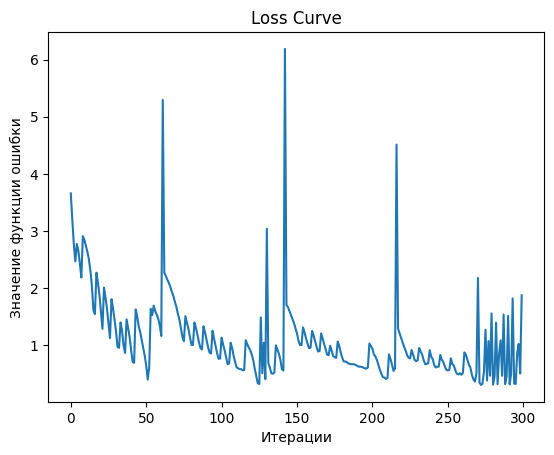

In [1948]:
# Оцените качество обученной модели (точность, матрица ошибок), взгляните на динамику изменения функции ошибки в ходе обучения.

# Напишите ваш код здесь.
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

y_pred = model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

plt.plot(loss)
plt.xlabel('Итерации')
plt.ylabel('Значение функции ошибки')
plt.title('Loss Curve')
plt.show()

#Несмотря на (относительно) хорошую точность, функция ошибок выглядит плохо

## 1.2 Анализ данных

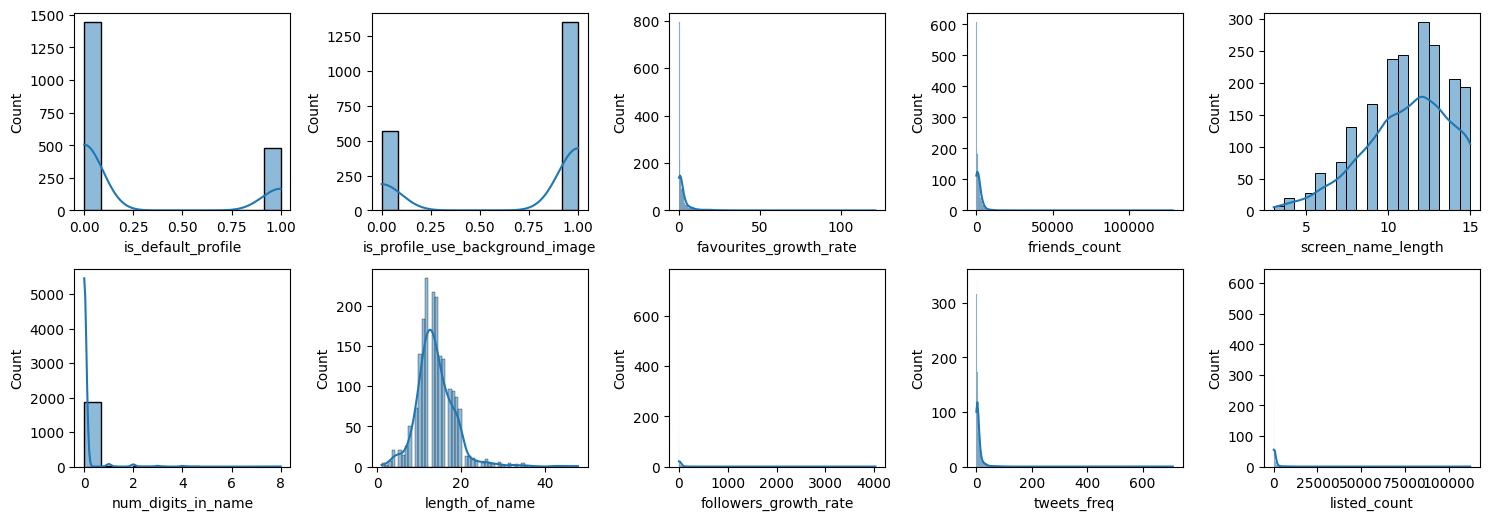

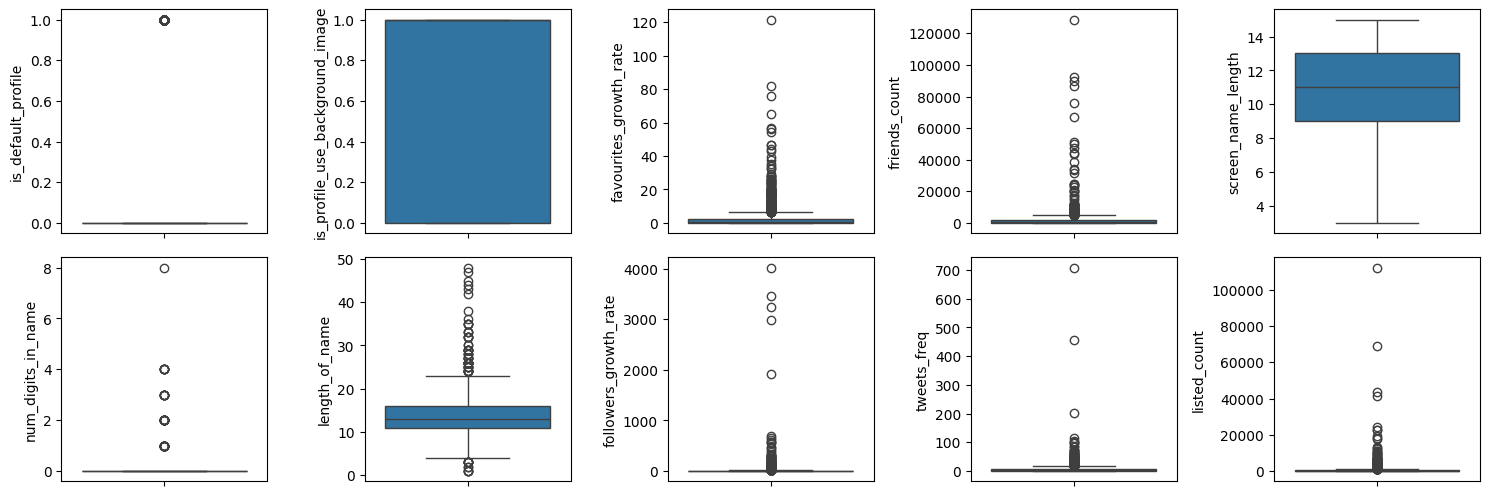

In [1949]:
# Проведите анализ данных (наличие выбросов, визуализация распределения отдельных признаков и т.д.).

import seaborn as sns

plt.figure(figsize=(15, 10))
for i, col in enumerate(x_train.columns, 1):
    plt.subplot(4, 5, i)
    sns.histplot(x_train[col], kde=True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
for i, col in enumerate(x_train.columns, 1):
    plt.subplot(4, 5, i)
    sns.boxplot(x_train[col])
plt.tight_layout()
plt.show()

In [1950]:
# 1. Опишите в данной клетке ваши наблюдения.
# 2. Предложите идеи к обработке/улучшению качества данных.

#Данные имеют выбросы, а также данные не нормированные, 
#Есть смысл нормировать данные и удалить выбросы
#Найдем и удалим выбросы с помощью z-оценки, 
#а потом пронормируем с помощью кубического корня (приблизим данные к нормальному распределению) и StandardScaler

## 1.3 Обработка данных

In [1951]:
# Реализуйте идеи по нормировке/улучшению качества данных.

# Напишите ваш код здесь.
# Реализуйте идеи по нормировке/улучшению качества данных.
from sklearn.preprocessing import StandardScaler
from scipy import stats

z_scores = stats.zscore(x_train)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
x_train_z = x_train[filtered_entries]
y_train_z = y_train[filtered_entries]

x_train_cbrt = np.cbrt(x_train_z)
x_test_cbrt = np.cbrt(x_test)

scaler = StandardScaler()
x_train_scaler = scaler.fit_transform(x_train_cbrt)
x_test_scaler = scaler.transform(x_test_cbrt)

## 1.4 Обучение итоговой модели

In [1952]:
# Обучите модель на трансформированных данных.

# Напишите ваш код здесь.
model_scaler = LogisticRegression(dim=10)
loss_scaler = model_scaler.fit(x_train_scaler, y_train_z.values.ravel())

Accuracy: 0.98125
F1 Score: 0.9577464788732394
Confusion Matrix:
[[369   3]
 [  6 102]]


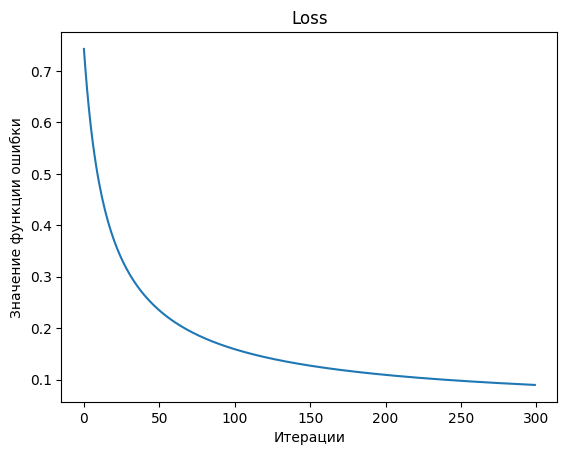

In [1953]:
# Оцените качество обученной модели (точность, матрица ошибок).
# Взгляните (matplotlib) на динамику изменения функции ошибки в ходе обучения.

# Напишите ваш код здесь.

y_pred = model_scaler.predict(x_test_scaler)

accuracy_scaler = accuracy_score(y_test, y_pred)
f1_scaler = f1_score(y_test, y_pred)
conf_matrix_scaler = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy_scaler}")
print(f"F1 Score: {f1_scaler}")
print(f"Confusion Matrix:\n{conf_matrix_scaler}")

plt.plot(loss_scaler)
plt.xlabel('Итерации')
plt.ylabel('Значение функции ошибки')
plt.title('Loss')
plt.show()

In [1954]:
# Сравните результат с моделью из пункта 1.1.
# Опишите выводы в этой клетке.

print(f"Accuracy без изменений: {accuracy}")
print(f"F1 Score без изменений: {f1}")
print('\n')
print(f"Accuracy с изменениями: {accuracy_scaler}")
print(f"F1 Score с изменениями: {f1_scaler}")

#После удаления выбросов с помощью z-оценки и нормализации точность улучшилась (немного).
#Модель лучше обучилась на данных без выбросов, что подняло точность до 0.98125, 
#а f1 улучшилось до 0.95, что говорит об улучшении производительности модели

Accuracy без изменений: 0.9708333333333333
F1 Score без изменений: 0.9326923076923077


Accuracy с изменениями: 0.98125
F1 Score с изменениями: 0.9577464788732394


## 2. Доп. задание (опционально)

В некоторых случаях вместо балансировки классов на уровне данных (как в ЛР1) используется балансировка на алгоритмическом уровне: 
взвешиваются значения функции ошибки для разных классов (большие веса используются для редких классов, малые веса для доминирующих классов), чтобы модель во время обучения 'фокусировалась' на редких классах. В данной лабораторной работе балансировка на уровне данных возможна, однако рассмотрение алгоритмического подхода даст вам еще один полезный практический инструмент.

Модифицируйте класс логистической регрессии так, чтобы во время обучения значения функции ошибки взвешивались для разных классов. 
Изменения будут представлять собой взвешивание индивидуальных градиентов (строки кода 28 и 29) для отдельных экземпляров данных.

Указание: не изменяйте код, связанный с вычислением `binary_cross_entropy`.

Сложность: энтузиаст-математик.

In [1955]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def binary_cross_entropy(pred, label):
    return -np.mean(label * np.log(pred + 1e-6) + (1. - label) * np.log(1 - pred + 1e-6))


class LogisticRegression:
    def __init__(self, dim=2, class_weight=None):
        rng = np.random.default_rng(seed=0)
        self.w = rng.normal(size=(dim, 1)) / np.sqrt(dim)
        self.b = np.zeros((1,))
        self.class_weight = class_weight
        
    def predict(self, x, probs=False):
        # x - np.array размерности [N, dim]
        #     Массив входных признаков.
        assert x.shape[1] == self.w.shape[0], \
            "Размерность экземпляров данных не соответствует ожидаемой: " + \
            f"ожидалось x.shape[1]={self.w.shape[0]}, но было получено x.shape[1]={x.shape[1]}"
        x = x.dot(self.w) + self.b
        p = sigmoid(x)
        if probs:
            return p
        return np.array(p > 0.5).astype('int32')
        
    def fit(self, x, y, iters=300, lr=0.1):
        # x - np.array размерности [N, dim]
        #     Массив входных признаков.
        # y - np.array размернсоти [N]
        #     Массив меток (правильных ответов).
        assert len(x) == len(y), \
            "Количество экземпляров в массиве X не равно количеству меток в массиве Y. " + \
            f"Полученные размеры: len(X) = {len(x)}, len(Y) = {len(y)}."
        assert x.shape[1] == self.w.shape[0], \
            "Размерность экземпляров данных не соответствует ожидаемой: " + \
            f"ожидалось x.shape[1]={self.w.shape[0]}, но было получено x.shape[1]={x.shape[1]}"
        
        # ВНЕСИТЕ МОДИФИКАЦИИ ЗДЕСЬ.
        # ----------------------------------------------------
        y = y.reshape(-1, 1)
        loss = []
        for i in range(iters):
            preds = self.predict(x, probs=True)
            if self.class_weight is not None:
                get_weight = np.vectorize(lambda label: self.class_weight[int(label)])
                weights = get_weight(y)
                self.w -= lr * x.T.dot(weights * (preds - y)) / y.shape[0]
                self.b -= lr * np.mean(weights * (preds - y), axis=0)
            else:
                self.w -= lr * x.T.dot(preds - y) / y.shape[0]
                self.b -= lr * np.mean(preds - y, axis=0)
            loss.append(binary_cross_entropy(preds, y))
        # ----------------------------------------------------
        return loss

### 2.1 Обучение без взвешивания

In [1956]:
# Создайте и обучите новую модель на данных из пункта 1.4 без использования взвешивания (коэффициенты 1/1). 
# Сохраните возвращенные значения функции ошибки, визуализируйте их.

# Напишите ваш код здесь.
class_weight = {0: 1, 1: 1}

model_weight_0 = LogisticRegression(dim=10, class_weight=class_weight)
loss_weight_0 = model_weight_0.fit(x_train_scaler, y_train_z.values.ravel())

In [1957]:
# Оцените качество обученной модели (точность, матрица ошибок).
# Убедитесь, что результаты схожи с результатами из пункта 1.4 (в идеале они должны быть равны).

# Напишите ваш код здесь.

y_pred = model_weight_0.predict(x_test_scaler)

accuracy_weight_0 = accuracy_score(y_test, y_pred)
f1_weight_0 = f1_score(y_test, y_pred)
conf_matrix_weight_0 = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy_weight_0}")
print(f"F1 Score: {f1_weight_0}")
print(f"Confusion Matrix:\n{conf_matrix_weight_0}")

#Результаты получились аналогичные результатам из пункта 1.4

Accuracy: 0.98125
F1 Score: 0.9577464788732394
Confusion Matrix:
[[369   3]
 [  6 102]]


### 2.2 Обучение с большим весом на классе 0

In [1958]:
# Создайте и обучите новую модель на данных из пункта 1.4 с большим весом на классе 0 (например 10|1) 
# Сохраните возвращенные значения функции ошибки.

# Напишите ваш код здесь.
class_weight = {0: 10, 1: 1}

model_weight_1 = LogisticRegression(dim=10, class_weight=class_weight)
loss_weight_1 = model_weight_1.fit(x_train_scaler, y_train_z.values.ravel())

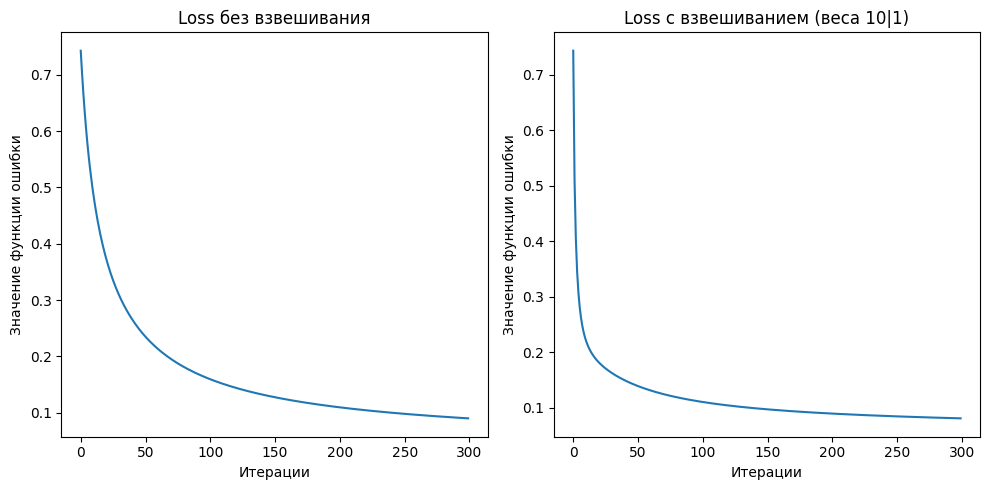

In [1959]:
# Визуализируйте значения функции ошибки из пункта 2.1 и из текущего пункта.

# Напишите ваш код здесь.
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(loss_weight_0)
axs[0].set_xlabel('Итерации')
axs[0].set_ylabel('Значение функции ошибки')
axs[0].set_title('Loss без взвешивания')

axs[1].plot(loss_weight_1)
axs[1].set_xlabel('Итерации')
axs[1].set_ylabel('Значение функции ошибки')
axs[1].set_title('Loss с взвешиванием (веса 10|1)')

plt.tight_layout()
plt.show()

In [1960]:
# Оцените качество обученной модели (точность, матрица ошибок).

# Напишите ваш код здесь.
y_pred = model_weight_1.predict(x_test_scaler)

accuracy_weight_1 = accuracy_score(y_test, y_pred)
f1_weight_1 = f1_score(y_test, y_pred)
conf_matrix_weight_1 = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy_weight_1}")
print(f"F1 Score: {f1_weight_1}")
print(f"Confusion Matrix:\n{conf_matrix_weight_1}")

Accuracy: 0.975
F1 Score: 0.9411764705882353
Confusion Matrix:
[[372   0]
 [ 12  96]]


In [1961]:
# Сравните матрицу ошибок с матрицей из пункта 2.1.

# Напишите ваши выводы здесь.
print(f"Confusion Matrix без взвешивания:\n{conf_matrix_weight_0}")
print("\n")
print(f"Confusion Matrix с взвешиванием (веса 10|1):\n{conf_matrix_weight_1}")

#Модель с весами 10|1 предсказывает класс 0 лучше, чем модель без весов, однако общее количество ошибок больше у модели с весами

Confusion Matrix без взвешивания:
[[369   3]
 [  6 102]]


Confusion Matrix с взвешиванием (веса 10|1):
[[372   0]
 [ 12  96]]


### 2.3 Обучение с большим весом на классе 1

In [1962]:
# Создайте и обучите новую модель на данных из пункта 1.4 с большим весом на классе 0 (например 1|10) 
# Сохраните возвращенные значения функции ошибки.

# Напишите ваш код здесь.
class_weight = {0: 1, 1: 10}

model_weight_2 = LogisticRegression(dim=10, class_weight=class_weight)
loss_weight_2 = model_weight_2.fit(x_train_scaler, y_train_z.values.ravel())

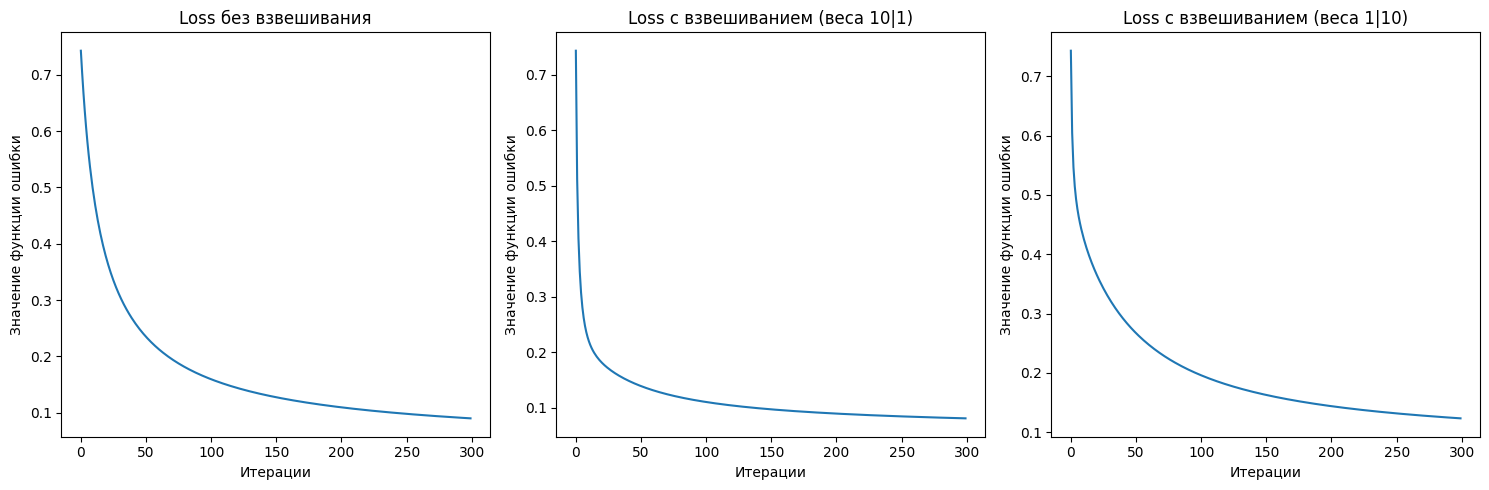

In [1963]:
# Визуализируйте значения функции ошибки из пунктов 2.1, 2.2 и из текущего пункта.

# Напишите ваш код здесь.

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(loss_weight_0)
axs[0].set_xlabel('Итерации')
axs[0].set_ylabel('Значение функции ошибки')
axs[0].set_title('Loss без взвешивания')

axs[1].plot(loss_weight_1)
axs[1].set_xlabel('Итерации')
axs[1].set_ylabel('Значение функции ошибки')
axs[1].set_title('Loss с взвешиванием (веса 10|1)')

axs[2].plot(loss_weight_2)
axs[2].set_xlabel('Итерации')
axs[2].set_ylabel('Значение функции ошибки')
axs[2].set_title('Loss с взвешиванием (веса 1|10)')

plt.tight_layout()
plt.show()

In [1964]:
# Оцените качество обученной модели (точность, матрица ошибок).

# Напишите ваш код здесь.
y_pred = model_weight_2.predict(x_test_scaler)

accuracy_weight_2 = accuracy_score(y_test, y_pred)
f1_weight_2 = f1_score(y_test, y_pred)
conf_matrix_weight_2 = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy_weight_2}")
print(f"F1 Score: {f1_weight_2}")
print(f"Confusion Matrix:\n{conf_matrix_weight_2}")

Accuracy: 0.9520833333333333
F1 Score: 0.9004329004329005
Confusion Matrix:
[[353  19]
 [  4 104]]


In [1965]:
# Сравните матрицу ошибок с матрицами из пунктов 2.1, 2.2.

# Напишите ваши выводы здесь.
print(f"Confusion Matrix без взвешивания:\n{conf_matrix_weight_0}")
print("\n")
print(f"Confusion Matrix с взвешиванием (веса 10|1):\n{conf_matrix_weight_1}")
print("\n")
print(f"Confusion Matrix с взвешиванием (веса 1|10):\n{conf_matrix_weight_2}")

#Модель с весами 1|10 предсказывает с наибольшим количеством ошибок, особенно для класса 0
#Наименьшее общее количество ошибок остается для модели без весов

Confusion Matrix без взвешивания:
[[369   3]
 [  6 102]]


Confusion Matrix с взвешиванием (веса 10|1):
[[372   0]
 [ 12  96]]


Confusion Matrix с взвешиванием (веса 1|10):
[[353  19]
 [  4 104]]


### 2.4 Обучение с оптимальными весами

In [1966]:
# Создайте и обучите новую модель на данных из пункта 1.4.
# Найдите веса, что дают более высокую точность, нежели точность из пункта 1.4.
# Сохраните возвращенные значения функции ошибки.

# Напишите ваш код здесь.

class_weight = {0: 11, 1: 4}

model_weight_3 = LogisticRegression(dim=10, class_weight=class_weight)
loss_weight_3 = model_weight_3.fit(x_train_scaler, y_train_z.values.ravel())


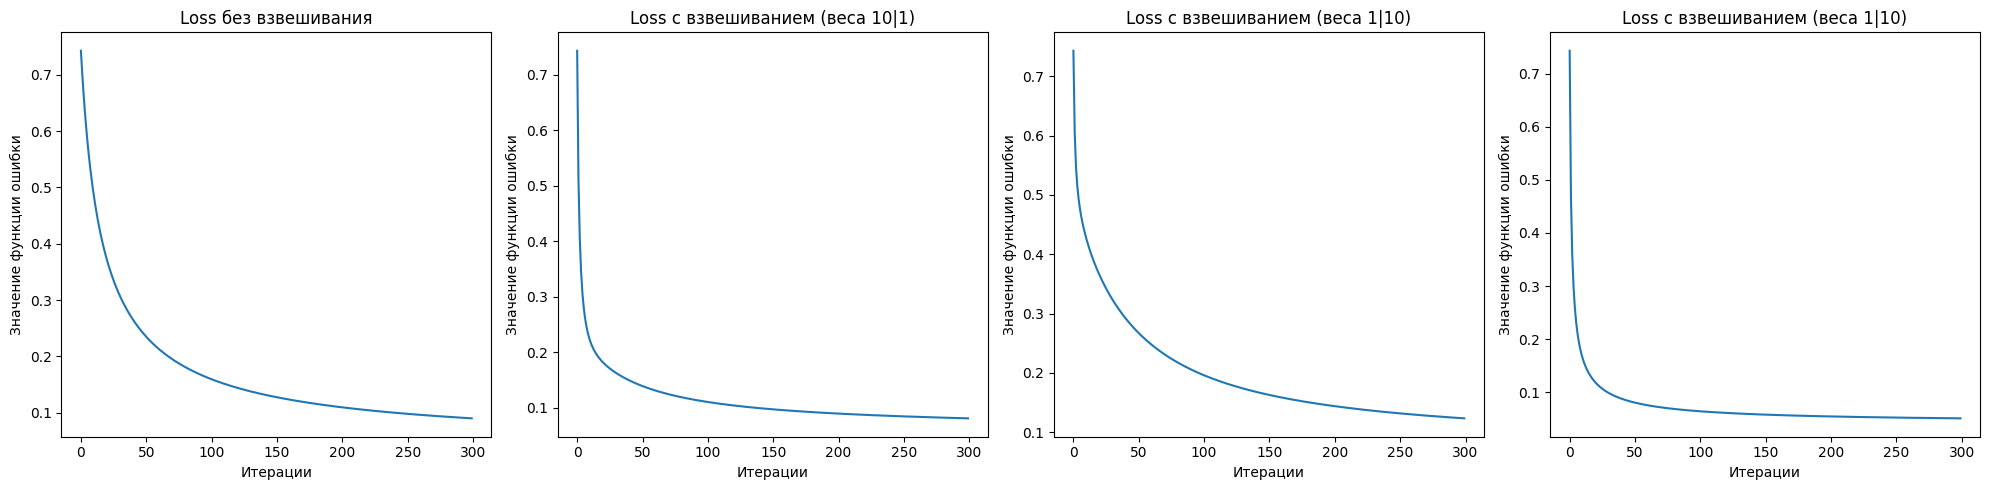

In [1967]:
# Визуализируйте значения функции ошибки из пунктов 2.1, 2.2, 2.3 и из текущего пункта.

# Напишите ваш код здесь.

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].plot(loss_weight_0)
axs[0].set_xlabel('Итерации')
axs[0].set_ylabel('Значение функции ошибки')
axs[0].set_title('Loss без взвешивания')

axs[1].plot(loss_weight_1)
axs[1].set_xlabel('Итерации')
axs[1].set_ylabel('Значение функции ошибки')
axs[1].set_title('Loss с взвешиванием (веса 10|1)')

axs[2].plot(loss_weight_2)
axs[2].set_xlabel('Итерации')
axs[2].set_ylabel('Значение функции ошибки')
axs[2].set_title('Loss с взвешиванием (веса 1|10)')

axs[3].plot(loss_weight_3)
axs[3].set_xlabel('Итерации')
axs[3].set_ylabel('Значение функции ошибки')
axs[3].set_title('Loss с взвешиванием (веса 1|10)')

plt.tight_layout()
plt.show()

In [1968]:
# Оцените качество обученной модели (точность, матрица ошибок).

# Напишите ваш код здесь.
y_pred = model_weight_3.predict(x_test_scaler)

accuracy_weight_3 = accuracy_score(y_test, y_pred)
f1_weight_3 = f1_score(y_test, y_pred)
conf_matrix_weight_3 = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy_weight_3}")
print(f"F1 Score: {f1_weight_3}")
print(f"Confusion Matrix:\n{conf_matrix_weight_3}")

Accuracy: 0.9854166666666667
F1 Score: 0.9665071770334929
Confusion Matrix:
[[372   0]
 [  7 101]]


In [1969]:
# Сравните матрицу ошибок с матрицей из пункта 2.1.

# Напишите ваши выводы здесь.
print(f"Confusion Matrix без взвешивания:\n{conf_matrix_weight_0}")
print("\n")
print(f"Confusion Matrix с взвешиванием (веса 10|1):\n{conf_matrix_weight_1}")
print("\n")
print(f"Confusion Matrix с взвешиванием (веса 1|10):\n{conf_matrix_weight_2}")
print("\n")
print(f"Confusion Matrix с взвешиванием (веса 11|4):\n{conf_matrix_weight_3}")

#Модель с оптимизированными весами показывает наилучший результат, предсказывая все реальные классы 0, 
#однако совершает больше ошибок в определении класса 1 по сравнению с весами 1|10 и без веса

Confusion Matrix без взвешивания:
[[369   3]
 [  6 102]]


Confusion Matrix с взвешиванием (веса 10|1):
[[372   0]
 [ 12  96]]


Confusion Matrix с взвешиванием (веса 1|10):
[[353  19]
 [  4 104]]


Confusion Matrix с взвешиванием (веса 11|4):
[[372   0]
 [  7 101]]
